In [1]:
!pip install -U classiq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3

In [ ]:
import classiq
classiq.authenticate()

# Designing the Quantum Walk Operator for the line with 16 nodes:

The Quantum walk is the quantum equivalent of the classical random walk. In this case, the walker moves with a superposition of states instead of definite states, resulting in complex interference patterns and faster spreading. This property makes it valuable in quantum algorithms such as search and optimization. Quantum walks come in two types: *discrete-time* and *continuous-time* quantum walk.

In [3]:
import numpy as np

In [4]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences

Imagine a series of 16 nodes arranged in a straight line, numbered from 0 to 15. Each node is connected to its immediate neighbors. A walker at any given node has an equal chance of moving to the node directly to its left or right.**

**0--1--2--3--4--5...--13--14--15**

In [5]:
size = 4               # 4 qubits to represent 16 vertices
num_nodes = 2**size    # Required Nodes (log_2(16))

The algorithm has two major operators:
- C Operator : it determines the probabilities associated to the walker's movements
- S Operator : it executes the actual movement

###**C Operator :**

Here, the C Operator establishes the probability of the walker's movement. The walker's state is changed by the C Operator by allocating amplitudes to move left or right from each node. Like, the C Operator will set the probability to advance to node 1 if the walker is at node 0. The probabilities of the walker moving to node 14 will be set if it is at node 15. That means, the probability is equally distributed to move left or right for nodes in between.

Next, we use the diffuser oracle to raise the probability of adjacent nodes.

In [6]:
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
        prob = [0] * num_nodes
        if i == 0:                  # we can't loop around when we are at the edges of the line
            prob[i + 1] = 1.0       # If at the first node, move to the right node (node 1)
        elif i == num_nodes - 1:
            prob[i - 1] = 1.0       # If at the last node, move to the left node (node 14)
        else:
            prob[i - 1] = 0.5       # Probability of moving to the left node
            prob[i + 1] = 0.5       # Probability of moving to the right node
            print(f'Node={i}, prob vec ={prob}')

        control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(num_nodes):
        C_iteration(i,vertices,adjacent_vertices)

###**S Operator :**

The S Operator is applied following the determination of the movement probabilities. In accordance with the amplitudes specified by the C Operator, this operator carries out the movement by switching the walker's state across nodes. The shift operator modifies the state to reflect the new locations if the walker's quantum state shows that it has moved from node 14 to nodes 13 and 15. Crucially, this is the stage when quantum interference may happen: the probability amplitudes of several routes combine to either increase or decrease the chance of specific events.

In [7]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i]))

@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

After creating the 2 neccessary steps ( C op. & S op. ), the walker is initialized in a superposition of every conceivable point along the line at the start of the procedure. **The Hadamard gate**, which generates an equal probability amplitude for the walker to be discovered at any of the 16 nodes, is a common example of a quantum gate used to do this. The starting state of the walker may be expressed theoretically as a superposition of basis states   **|0⟩, |1⟩...., |15⟩** where each basis state is associated with a node.

###**Quantum Walk Operator**

In [8]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    allocate(size, vertices)    # Allocating qubits for vertices
    hadamard_transform(vertices)    # Applying Hadamard transform to initialize superposition
    allocate(size, adjacent_vertices)    # Again Allocating qubits for adjacent vertices

    C_operator(vertices, adjacent_vertices)  # Applying The C Operator
    S_operator(vertices, adjacent_vertices)  # Applying  The S Operator

In [9]:
# Create and synthesize the quantum walk operator model
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node=14, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5]
O

We can see below that we have succesfully implemented our proposed method.

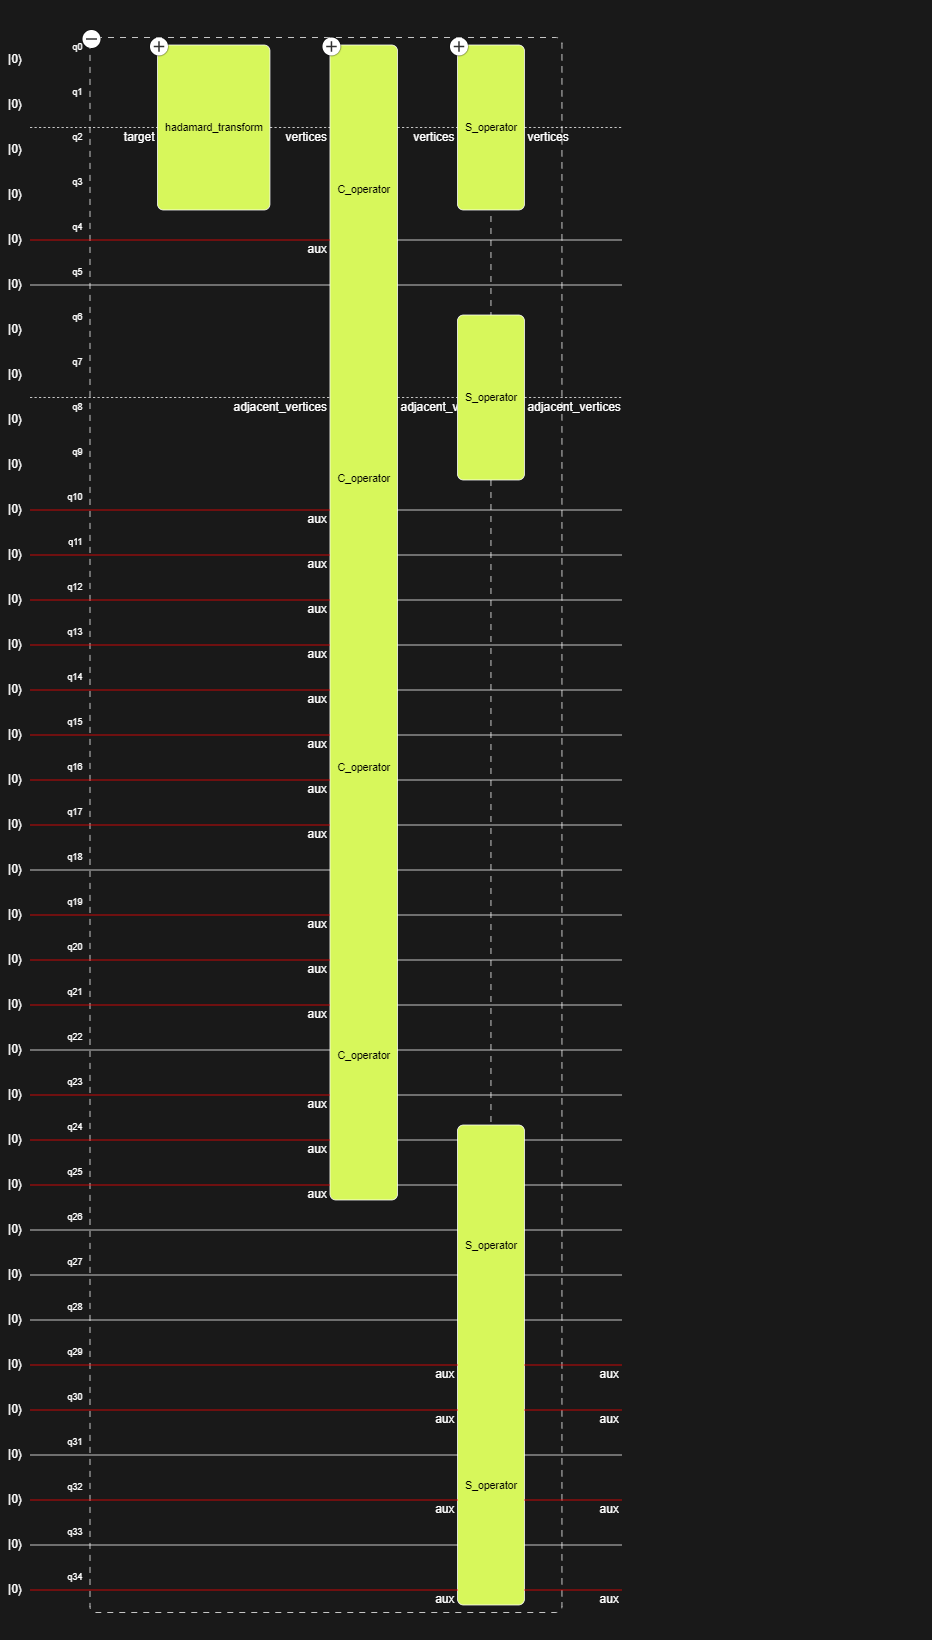

The below figure represents the implementation of the C operator.

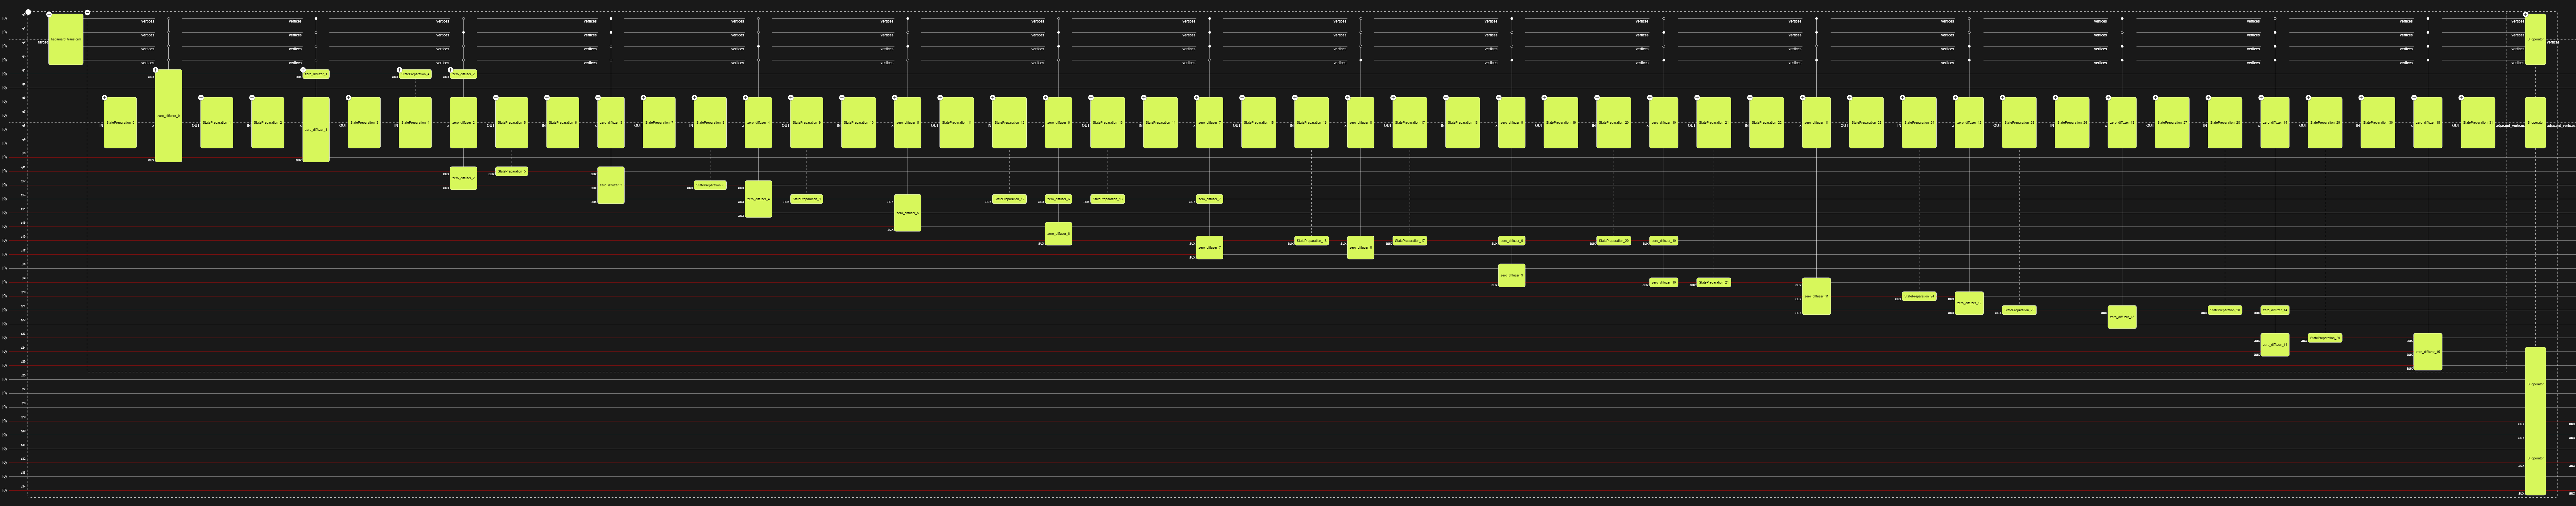

The below figure represents the implementation of S operator.

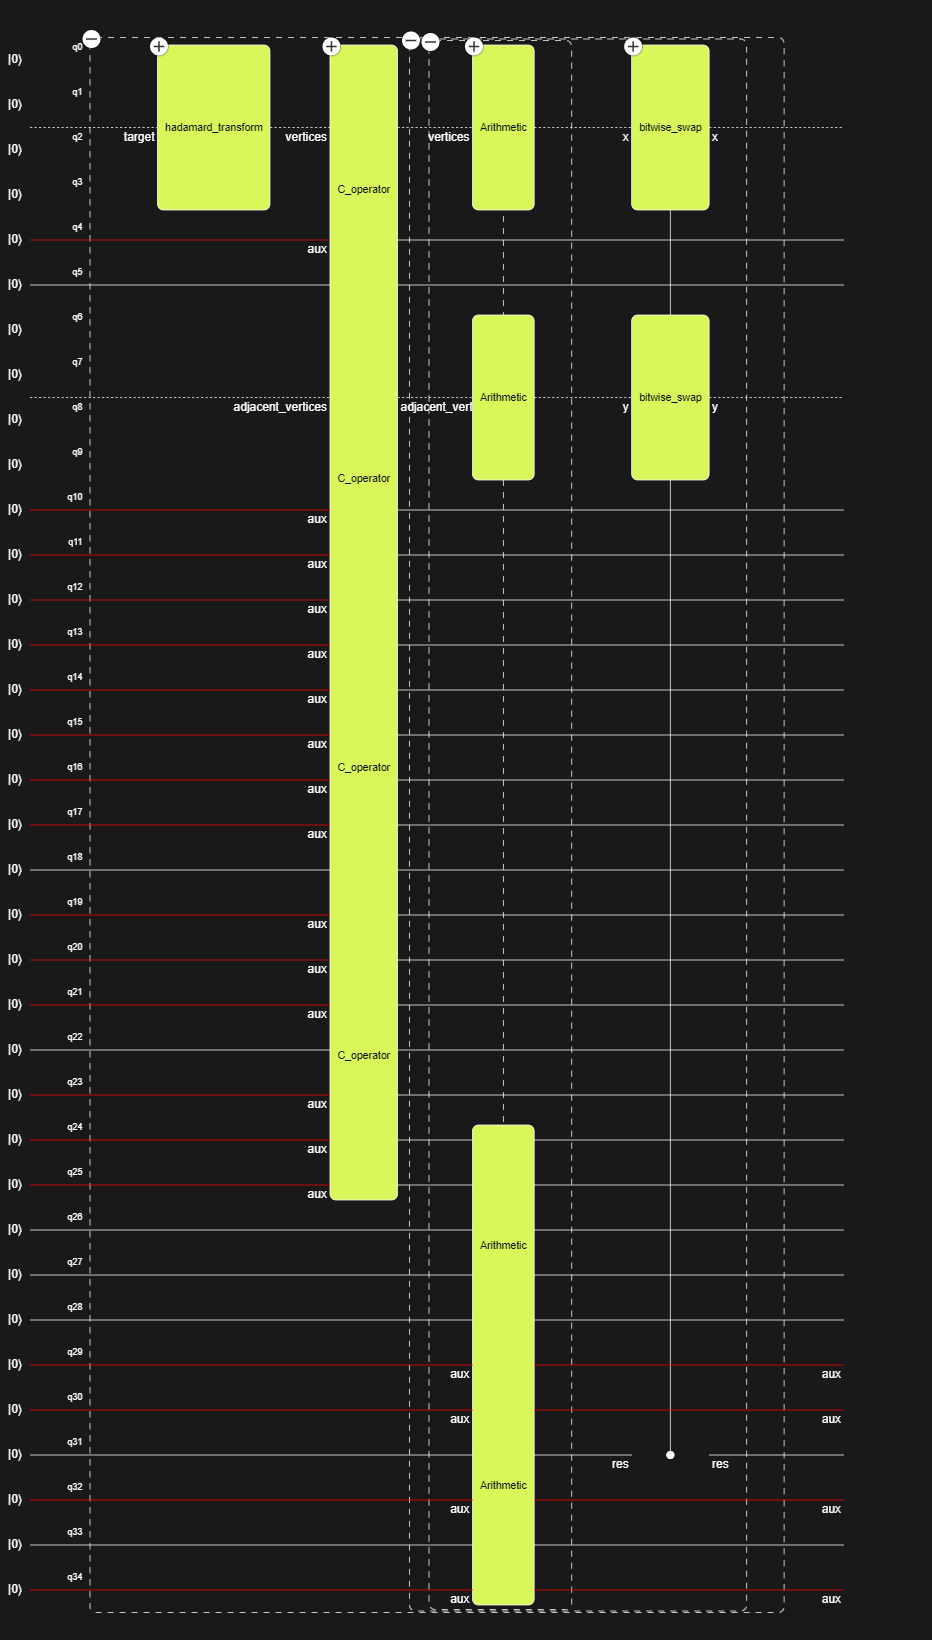